# Data Preprocessing

- Missing value imputation
- Rare category
- Feature Transformation and Scaling

## Split Train and Validate Set
 Split ratio $=$ train ($80$) $:$ validate ($20$)

In [ ]:
X = train_data.copy()

In [ ]:
train_index, validate_index = train_test_split(X.is_promoted, test_size=0.2, stratify=X.is_promoted, random_state=1)
train_index, validate_index = train_index.index, validate_index.index

In [ ]:
del train_data

## Missing value Imputation

### `education`

In [ ]:
education_imputer = SimpleImputer(strategy='constant', fill_value='missing')

In [ ]:
# fit using train data only
education_imputer.fit(np.array(X.education[train_index]).reshape(-1,1))

SimpleImputer(add_indicator=False, copy=True, fill_value='missing',
              missing_values=nan, strategy='constant', verbose=0)

In [ ]:
# Transform whole dataset
X.education = education_imputer.transform(np.array(X.education).reshape(-1,1))

### `previous_year_rating` [TODO : Need for functional imputer]

In [ ]:
def rating_na_indicator(column):
    '''
        :column : An iterable. if scalar will be converted to iterable.
        It returns an indicator variable; 1 if nan else 0
    '''

    column = pd.Series(column)

    indicator_column = column.apply(lambda x : 1 if np.isnan(x) else 0 )

    return indicator_column

In [ ]:
def rating_corrected(data):
    '''
        If length of service = 1, then previous years rating cannot exist
        This function substitues values as such with np.nan. 
        Expectation is to treat the value same as missing vale would be treated.

        Parameter
        --------------------------------
        :data : Dataframe of training data with atleast `previous_year_rating`
                and `length_of_service`

        Returns
        ---------------
        A column with values substituted to np.nan if length of service =1 
        and pevious_year_rating != nan, else same value as already present.
    '''
    
    rating = np.where((data.length_of_service == 1) & (data.previous_year_rating.notna()), np.nan, data.previous_year_rating)

    return rating

In [ ]:
def preprocess_rating(data):

    data['previous_year_rating'] = rating_corrected(data)
    rating_na = rating_na_indicator(data['previous_year_rating'])
    
    return data['previous_year_rating'], rating_na

In [ ]:
rating_imputer = SimpleImputer(strategy='most_frequent')

In [ ]:
X.previous_year_rating, X['previous_rating_na'] = preprocess_rating(X)

In [ ]:
# fit only on training data
rating_imputer.fit(np.array(X.previous_year_rating[train_index]).reshape(-1,1))

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [ ]:
# transform all data
X.previous_year_rating = rating_imputer.transform(np.array(X.previous_year_rating).reshape(-1,1))

## Handle high cardinality of `region`

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CardinalityImputer(BaseEstimator, TransformerMixin):

    def __init__(self, threshold, replace_term='rare_region'):

        self.threshold = threshold
        self.replace_term = replace_term

        self.rare_category = []

    def only_one_col(self, column):

        column = np.array(column)
        return len(column.shape) == 1


    def find_rare_category(self, feature, threshold):
    
        '''
            Finds categories that are smaller than threshold percentage.
            This function is similar to fit() of any transformer.

            Parameter
            --------------------
            :feature : should be one column.
                    expected to be of training data 
            :threshold : frequency threshold in percentage


        '''
        #feature = pd.Series(feature)

        rare_category = np.array(feature.value_counts(dropna=False)[
                        (feature.value_counts(dropna=False)/feature.shape[0])*100 < threshold
                    ].index)
        
        return rare_category


    def fit(self, feature):

        if not self.only_one_col(feature):
            raise ValueError('''Only One Feature Can be processed.
                             More than one Column provided.''')
        
        feature = pd.Series(feature)

        #self.rare_category = find_rare_category(feature[train_index], 1)
        self.rare_category = self.find_rare_category(feature, 1)

        return self

    
    def transform(self, feature):

        if not self.only_one_col(feature):
            raise ValueError('''Only One Feature Can be processed.
                             More than one Column provided.''')
            
        feature = pd.Series(feature)

        feature = feature.apply(lambda x: self.replace_term if x in self.rare_category else x)

        return feature

In [ ]:
region_cardinality_imputer = CardinalityImputer(1, replace_term='rare_region')

In [ ]:
region_cardinality_imputer.fit(X.region[train_index])

CardinalityImputer(replace_term='rare_region', threshold=1)

In [ ]:
X.region = region_cardinality_imputer.transform(X.region)

## Scale and Transform Numerical data

- Use PowerTrasformer with 'yeo-johnson' method. First transforms the data; attempting towards Gaussian and then standardizes.

In [ ]:
numerical_features = ['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']

### Power Transform : `Yeo-Johnson`

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
yeo_johnson_data = X.loc[:, numerical_features]

In [ ]:
for num_var in yeo_johnson_data.columns:
    # fit with training data
    transformer = PowerTransformer(standardize=True).fit(np.array(yeo_johnson_data[num_var][train_index]).reshape(-1,1))
    # transform your data
    yeo_johnson_data[num_var] = transformer.transform(np.array(yeo_johnson_data[num_var]).reshape(-1,1))

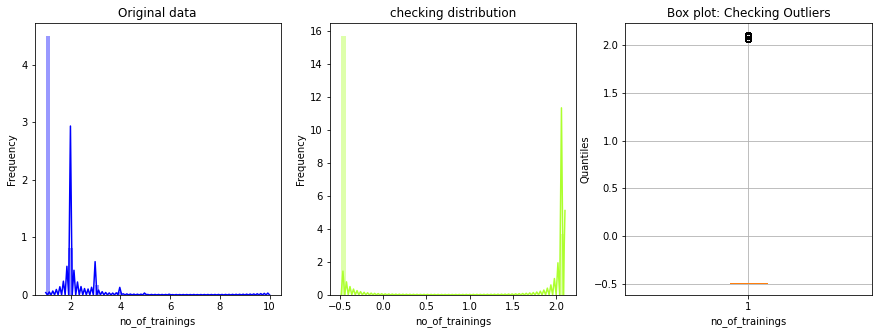

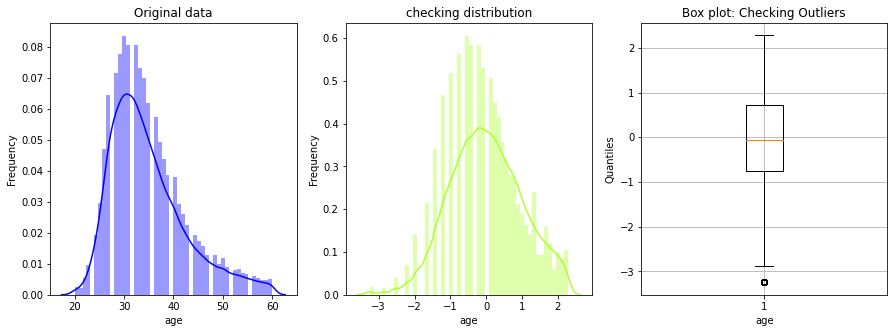

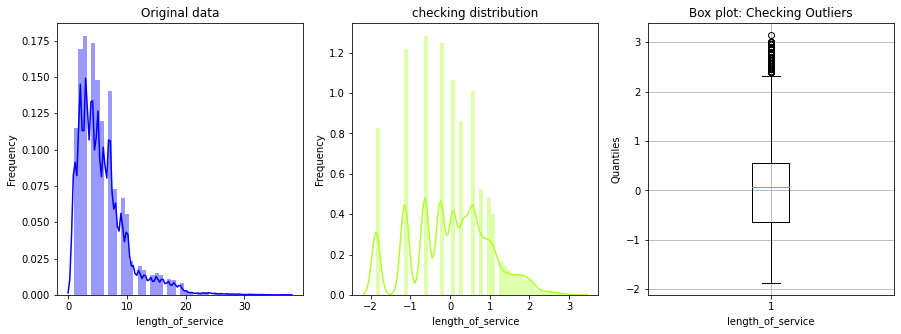

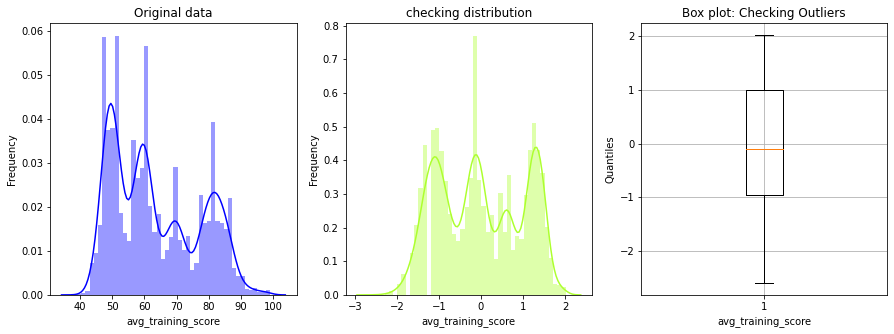

In [ ]:
for feature in yeo_johnson_data.columns:

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    plt.subplot(ax[0])
    sns.distplot(X.loc[:, feature], color='blue')
    plt.title('Original data')
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    
    plt.subplot(ax[1])
    sns.distplot(yeo_johnson_data.loc[:, feature], color='greenyellow')
    plt.title('checking distribution')
    plt.ylabel('Frequency')
    plt.xlabel(feature)

    plt.subplot(ax[2])
    plt.boxplot(yeo_johnson_data.loc[:, feature])
    #plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.xlabel(feature)
    plt.ylabel('Quantiles')
    plt.title('Box plot: Checking Outliers')
    plt.grid()


    plt.show()

In [ ]:
del yeo_johnson_data